# The MD simulation of the SARS-CoV-2 N protein RNA-binding domain bound to single-domain antibody B6

## 1. import the module we need

Here, we use the amber force field ff14sb for protein and tip3p for water.

In [1]:
import mindsponge.toolkits as Xponge
Xponge.source("mindsponge.toolkits.forcefield.amber.ff14sb")
Xponge.source("mindsponge.toolkits.forcefield.amber.tip3p")
from mindsponge.toolkits.mdrun import run
from mindsponge.toolkits.analysis import MdoutReader

Reference for ff14SB:
  James A. Maier, Carmenza Martinez, Koushik Kasavajhala, Lauren Wickstrom, Kevin E. Hauser, and Carlos Simmerling
    ff14SB: Improving the accuracy of protein side chain and backbone parameters from ff99SB
    Journal of Chemical Theory and Computation 2015 11 (8), 3696-3713
    DOI: 10.1021/acs.jctc.5b00255

Reference for tip3p:
1. Water:
  William L. Jorgensen, Jayaraman Chandrasekhar, and Jeffry D. Madura
    Comparison of simple potential functions for simulating liquid water
    The Journal of Chemical Physics 1983 79, 926-935, 
    DOI: 10.1063/1.445869

2. Li+, Na+, K+, Rb+, Cs+, F-, Cl-, Br-, I-:
  In Suk Joung and Thomas E. Cheatham
    Determination of Alkali and Halide Monovalent Ion Parameters for Use in Explicitly Solvated Biomolecular Simulations
    The Journal of Physical Chemistry B 2008 112 (30), 9020-9041
    DOI: 10.1021/jp8001614

3. Ag+, Tl+, Cu+:
  Pengfei Li, Lin Frank Song, and Kenneth M. Merz
    Systematic Parameterization of Monovalen

## 2. get a Molecule instance

Here, the structure is downloaded from RCSB using the command `wget`. There are missing hydrogen atoms in the structure downloaded from the website, so we need to add missing atoms. The names of hydrogen atoms does not match  with the templates in the force field, we just ignore these atoms and add missing atoms.

In [2]:
!wget https://files.rcsb.org/download/7R98.pdb

--2022-07-31 14:01:59--  https://files.rcsb.org/download/7R98.pdb
Connecting to 127.0.0.1:44649... connected.
Proxy request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7R98.pdb.1’

7R98.pdb.1              [     <=>            ]   1.33M  1.14MB/s    in 1.2s    

2022-07-31 14:02:01 (1.14 MB/s) - ‘7R98.pdb.1’ saved [1396683]



In [3]:
mol = load_pdb("7R98.pdb", ignore_hydrogen=True)
mol.Add_Missing_Atoms()

## 3. set the periodic box conditions

First, we add a 10-Angstrom-thick water layer to the molecule. Then, the molecule may be not neutral, so we need to add ions to nertralize the molecule, here I put 10 K+ and 14 Cl-.

In [4]:
print(mol.charge)

4.0000000000000515


In [5]:
Add_Solvent_Box(mol, WAT, 10)
Solvent_Replace(mol, lambda res: res.name == "WAT", {K:10, CL:14})

In [6]:
print(mol.charge)

6.572520305780927e-14


## 4. save the input

In [7]:
Save_PDB(mol, "covid.pdb")
Save_SPONGE_Input(mol, "covid")

## 5. do the minimization

The minimization is used to relax the structure a little bit, so that we can do the MD simulation in a proper time step. We do not need to find the local minima. The first step is to do the steepest minimization with a dynamic learning rate, and the learning rate increases expotionally, which may cause nan but it does not matter. The second step we fix the time step to 1e-3, and we can get a minimized structure which will not crash down at the time step.

In [8]:
run("""SPONGE
-mode minimization
-minimization_dynamic_dt 1
-constrain_mode SHAKE
-step_limit 2500
-default_in_file_prefix covid
-write_information_interval 500
-rst min
""")
run(f"""SPONGE
-mode minimization
-dt 1e-3
-constrain_mode SHAKE
-step_limit 2500
-write_information_interval 500
-default_in_file_prefix covid
-coordinate_in_file min_coordinate.txt
-rst min
""")

SPONGE Version:
    v1.2.6.0 2022-08-01

Citation:
    Huang, Y. - P., Xia, Y., Yang, L., Wei, J., Yang, Y.I.and Gao, Y.Q. (2022), SPONGE: A GPU - Accelerated Molecular Dynamics Package with Enhanced Sampling and AI - Driven Algorithms.Chin.J.Chem., 40 : 160 - 168. https ://doi.org/10.1002/cjoc.202100456


MD TASK NAME:
    Default SPONGE MD Task Name

START INITIALIZING CONTROLLER
    Start initializing CUDA
        1 device found:
            Device 0:
                Name: NVIDIA GeForce RTX 2080 SUPER
                Memory: 7.8 GB
        Set Device 0
    End initializing CUDA
    structure last modify date is 20210827
END INITIALIZING CONTROLLER

START INITIALIZING MD CORE:
    Mode set to Energy Minimization
    dt set to 0.000000 ps
    Start reading coordinate_in_file:
        atom_numbers is 38531
        system start_time is 0.000000
        box_length is
            x: 120.521263
            y: 120.798813
            z: 87.000000
    End reading coordinate_in_file

    Velo

     nb14_LJ =      3331.54,      nb14_EE =     27213.35,         bond =       655.85, 
       angle =     12376.58,     dihedral =     10534.94, 
---------------------------------------------------------------------------------------
        step =         1000,         time =        0.000,  temperature =         0.04, 
   potential =    -49010.12,           LJ =     -7012.71,          PME =    -91205.03, 
     nb14_LJ =      2694.21,      nb14_EE =     26870.39,         bond =       579.01, 
       angle =      8557.94,     dihedral =     10488.50, 
---------------------------------------------------------------------------------------
        step =         1500,         time =        0.000,  temperature =         0.03, 
   potential =    -55729.56,           LJ =     -7034.22,          PME =    -96045.62, 
     nb14_LJ =      2505.55,      nb14_EE =     26803.64,         bond =       561.58, 
       angle =      7088.95,     dihedral =     10381.56, 
-------------------------------

## 6. control the temperature

It needs to control the temperature of the system to our target temperature

In [9]:
run("""SPONGE
-mode NVT
-thermostat middle_langevin
-target_temperature 300
-dt 2e-3
-constrain_mode SHAKE
-step_limit 10000
-default_in_file_prefix covid
-coordinate_in_file min_coordinate.txt
-crd heat.dat
-rst heat
-mdout heat.out
""")

SPONGE Version:
    v1.2.6.0 2022-08-01

Citation:
    Huang, Y. - P., Xia, Y., Yang, L., Wei, J., Yang, Y.I.and Gao, Y.Q. (2022), SPONGE: A GPU - Accelerated Molecular Dynamics Package with Enhanced Sampling and AI - Driven Algorithms.Chin.J.Chem., 40 : 160 - 168. https ://doi.org/10.1002/cjoc.202100456


MD TASK NAME:
    Default SPONGE MD Task Name

START INITIALIZING CONTROLLER
    Start initializing CUDA
        1 device found:
            Device 0:
                Name: NVIDIA GeForce RTX 2080 SUPER
                Memory: 7.8 GB
        Set Device 0
    End initializing CUDA
    structure last modify date is 20210827
END INITIALIZING CONTROLLER

START INITIALIZING MD CORE:
    Mode set to NVT
    dt set to 0.002000 ps
    Start reading coordinate_in_file:
        atom_numbers is 38531
        system start_time is 0.000000
        box_length is
            x: 120.521263
            y: 120.798813
            z: 87.000000
    End reading coordinate_in_file

    Velocity is set to z

## 7. control the pressure

It needs to control the pressure of the system to our target pressure

In [10]:
run("""SPONGE
-mode NPT
-thermostat middle_langevin
-target_temperature 300
-barostat andersen_barostat
-target_pressure 1
-dt 2e-3
-constrain_mode SHAKE
-step_limit 30000
-default_in_file_prefix covid
-coordinate_in_file heat_coordinate.txt
-velocity_in_file heat_velocity.txt
-crd press.dat
-rst press
-mdout press.out
""")

SPONGE Version:
    v1.2.6.0 2022-08-01

Citation:
    Huang, Y. - P., Xia, Y., Yang, L., Wei, J., Yang, Y.I.and Gao, Y.Q. (2022), SPONGE: A GPU - Accelerated Molecular Dynamics Package with Enhanced Sampling and AI - Driven Algorithms.Chin.J.Chem., 40 : 160 - 168. https ://doi.org/10.1002/cjoc.202100456


MD TASK NAME:
    Default SPONGE MD Task Name

START INITIALIZING CONTROLLER
    Start initializing CUDA
        1 device found:
            Device 0:
                Name: NVIDIA GeForce RTX 2080 SUPER
                Memory: 7.8 GB
        Set Device 0
    End initializing CUDA
    structure last modify date is 20210827
END INITIALIZING CONTROLLER

START INITIALIZING MD CORE:
    Mode set to NPT
    dt set to 0.002000 ps
    Start reading coordinate_in_file:
        atom_numbers is 38531
        system start_time is 20.000000
        box_length is
            x: 120.521263
            y: 120.798813
            z: 87.000000
    End reading coordinate_in_file

    Start reading veloc

       angle =      6161.14,     dihedral =      9760.28,      density =       1.0036, 
    pressure =      -163.97,        dV/dt =      -237.59, 
---------------------------------------------------------------------------------------
        step =        15000,         time =       50.000,  temperature =       305.37, 
   potential =   -103952.64,           LJ =      6408.38,          PME =   -157694.12, 
     nb14_LJ =      2410.53,      nb14_EE =     26818.90,         bond =      2120.30, 
       angle =      6154.04,     dihedral =      9799.76,      density =       1.0195, 
    pressure =      -212.91,        dV/dt =      -238.80, 
---------------------------------------------------------------------------------------
        step =        16000,         time =       52.000,  temperature =       301.93, 
   potential =   -104380.27,           LJ =      6487.64,          PME =   -158170.53, 
     nb14_LJ =      2393.03,      nb14_EE =     26832.69,         bond =      2189.25, 
  

## 8. do the production simulation

Now we can do the production simulation. The steps above should be chosen wisely. For example, some simple systems do not need to minimize them, but some complicated systems may need to do more complecated minimization and pre-equilibration

In [11]:
run("""SPONGE
-mode NPT
-thermostat middle_langevin
-target_temperature 300
-barostat andersen_barostat
-target_pressure 1
-dt 2e-3
-constrain_mode SHAKE
-step_limit 50000
-default_in_file_prefix covid
-coordinate_in_file press_coordinate.txt
-velocity_in_file press_velocity.txt
-crd product.dat
-rst product
-mdout product.out
""")

SPONGE Version:
    v1.2.6.0 2022-08-01

Citation:
    Huang, Y. - P., Xia, Y., Yang, L., Wei, J., Yang, Y.I.and Gao, Y.Q. (2022), SPONGE: A GPU - Accelerated Molecular Dynamics Package with Enhanced Sampling and AI - Driven Algorithms.Chin.J.Chem., 40 : 160 - 168. https ://doi.org/10.1002/cjoc.202100456


MD TASK NAME:
    Default SPONGE MD Task Name

START INITIALIZING CONTROLLER
    Start initializing CUDA
        1 device found:
            Device 0:
                Name: NVIDIA GeForce RTX 2080 SUPER
                Memory: 7.8 GB
        Set Device 0
    End initializing CUDA
    structure last modify date is 20210827
END INITIALIZING CONTROLLER

START INITIALIZING MD CORE:
    Mode set to NPT
    dt set to 0.002000 ps
    Start reading coordinate_in_file:
        atom_numbers is 38531
        system start_time is 80.000000
        box_length is
            x: 80.837944
            y: 81.024162
            z: 58.353981
    End reading coordinate_in_file

    Start reading velocit

   potential =   -106605.98,           LJ =      6536.03,          PME =   -160211.69, 
     nb14_LJ =      2402.38,      nb14_EE =     26969.51,         bond =      2169.71, 
       angle =      6027.21,     dihedral =      9535.18,      density =       1.0747, 
    pressure =       350.48,        dV/dt =       162.86, 
---------------------------------------------------------------------------------------
        step =        18000,         time =      116.000,  temperature =       302.13, 
   potential =   -106628.44,           LJ =      6488.64,          PME =   -160283.78, 
     nb14_LJ =      2431.93,      nb14_EE =     26921.40,         bond =      2208.30, 
       angle =      6098.40,     dihedral =      9502.30,      density =       1.0778, 
    pressure =       -14.74,        dV/dt =       154.65, 
---------------------------------------------------------------------------------------
        step =        19000,         time =      118.000,  temperature =       298.93, 
  

    pressure =        82.84,        dV/dt =      -215.79, 
---------------------------------------------------------------------------------------
        step =        34000,         time =      148.000,  temperature =       302.65, 
   potential =   -106842.05,           LJ =      6432.97,          PME =   -160332.19, 
     nb14_LJ =      2436.43,      nb14_EE =     27021.57,         bond =      2126.08, 
       angle =      5969.17,     dihedral =      9541.40,      density =       1.0780, 
    pressure =        88.57,        dV/dt =      -170.08, 
---------------------------------------------------------------------------------------
        step =        35000,         time =      150.000,  temperature =       295.09, 
   potential =   -106884.13,           LJ =      6767.79,          PME =   -160635.78, 
     nb14_LJ =      2408.29,      nb14_EE =     26963.12,         bond =      2137.25, 
       angle =      6009.75,     dihedral =      9479.82,      density =       1.0805, 
  

## 9. see the results

You can also download the pdb and trajectory files to your PC, and use VMD to visualize the trajectory

In [14]:
mdout = MdoutReader("product.out")

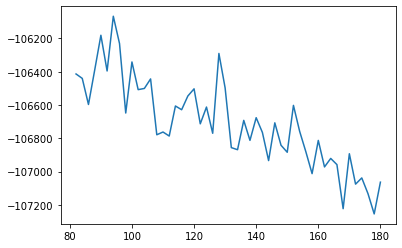

In [15]:
import matplotlib.pyplot as plt
plt.plot(mdout.time, mdout.potential)
plt.show()

## 10. discuss

From the results we get, we can conclude that the simulation is not at equilibrium because the total potential is still decreasing. So maybe you need to set `step_limit` larger or continue to run many times yourself.